In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses

In [2]:
np.random.seed(1)

# Load MNIST dataset

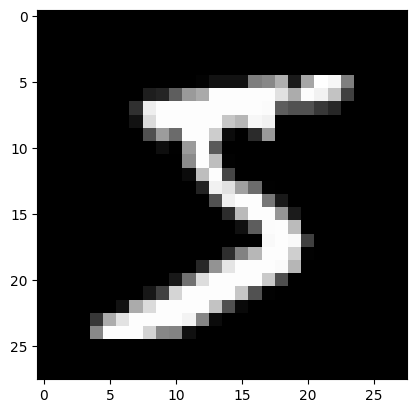

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

# Self supervised learning method

## Define autoencoder

In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0238 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.004

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

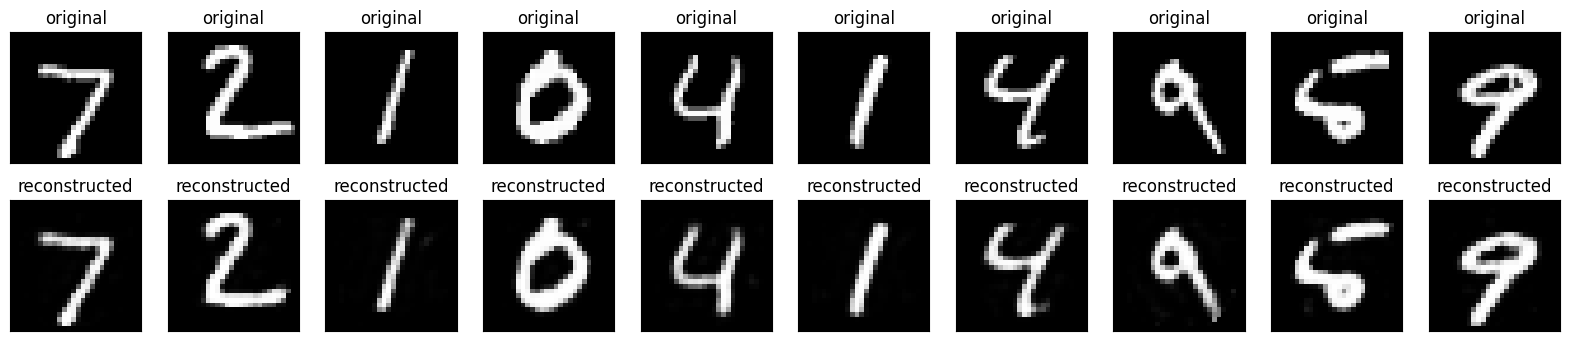

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Adding noise

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

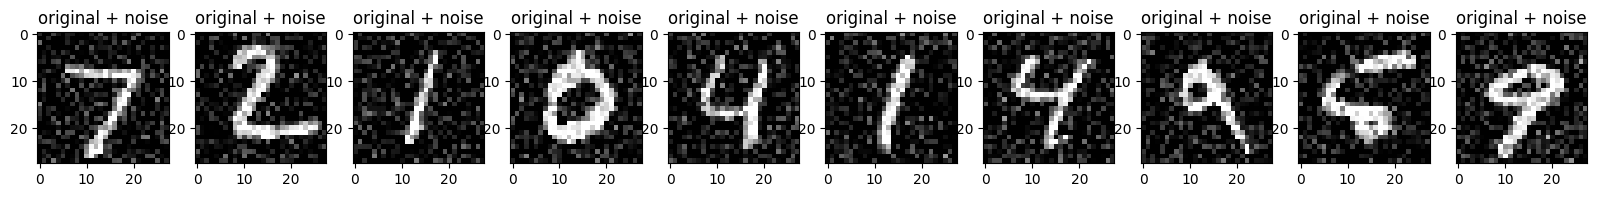

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Define a convolutional autoencoder

In [27]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder_denoise = Denoise()

In [28]:
autoencoder_denoise.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [29]:
autoencoder_denoise.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 45s 23ms/step - loss: 0.0162 - val_loss: 0.0038
Epoch 2/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
1875/1875 [==============================] - 45s 24m

In [30]:
autoencoder_denoise.encoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
encoded_noisy_imgs = autoencoder_denoise.encoder(x_test_noisy).numpy()
decoded_noisy_imgs = autoencoder_denoise.decoder(encoded_noisy_imgs).numpy()

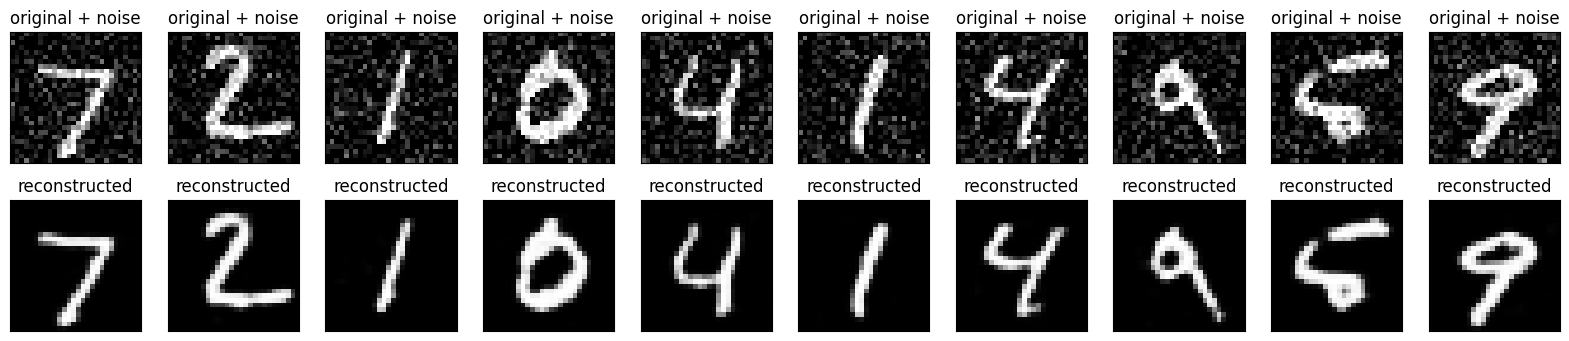

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_noisy_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Supervised learning method

In [ ]:
# Extract the encoder part for later use
pretrain_encoder = Model(inputs=autoencoder_denoise.input, outputs=autoencoder_denoise.encoder.output)

# Step 2: Fine-tuning (Supervised)
fine_tune_epochs = 10
fine_tune_encoder = Denoise().encoder

# Set the pretrained weights to the fine-tune encoder
fine_tune_encoder.set_weights(pretrain_encoder.get_weights())

# Add classification layers
classification_model = Sequential([
    fine_tune_encoder,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the fine-tune model
classification_model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming you have a small labeled dataset for fine-tuning (1% of the training data)
num_labeled_samples = int(0.01 * len(x_train))
labeled_indices = np.random.choice(len(x_train), num_labeled_samples, replace=False)

# Fine-tune the model on the labeled data
classification_model.fit(x_train[labeled_indices], y_train[labeled_indices], epochs=fine_tune_epochs, batch_size=64)

# Evaluate on the test set
accuracy = classification_model.evaluate(x_test, y_test)[1]
print("Test Accuracy:", accuracy)

# Compare results

## Compare autoencoders with SSIM score

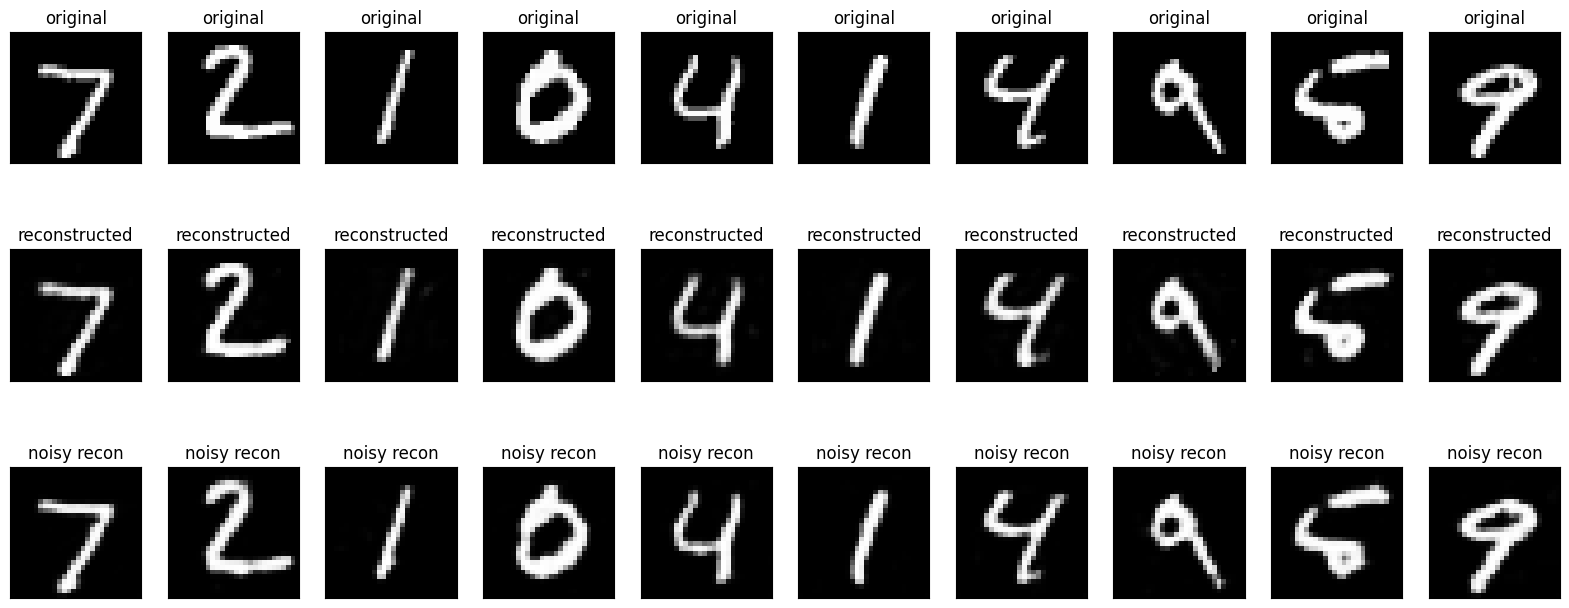

tf.Tensor(0.92024845, shape=(), dtype=float32)
tf.Tensor(0.95846444, shape=(), dtype=float32)


In [53]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display noisy reconstruction
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(decoded_noisy_imgs[i])
  plt.title("noisy recon")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

orig_imgs = x_test
dec_imgs = [tf.reshape(img, shape=(28, 28, 1)) for img in decoded_imgs]
dec_noisy_imgs = decoded_noisy_imgs

ssim = tf.image.ssim(orig_imgs, dec_imgs, max_val=1.0)
average_ssim = tf.reduce_mean(ssim)
print(average_ssim)

ssim = tf.image.ssim(orig_imgs, dec_noisy_imgs, max_val=1.0)
average_ssim = tf.reduce_mean(ssim)
print(average_ssim)